<a href="https://colab.research.google.com/github/ProfAI/machine-learning-fondamenti/blob/main/Progetto%20Finale%20-%20Cross%20Selling%20di%20Polizze/health_insurance_cross_sell_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### `Previsione di opportunità di Cross Sell di assicurazioni`

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

Il dataset è composto dalle seguenti proprietà:
- **id**: id univoco dell'acquirente.
- **Gender**: sesso dell'acquirente.
- **Age**: età dell'acquirente.
- **Driving_License**: 1 se l'utente ha la patente di guida, 0 altrimenti.
- **Region_Code**: codice univoco della regione dell'acquirente.
- **Previously_Insured**: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.
- **Vehicle_Age**: età del veicolo
- **Vehicle_Damage**: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.
- **Annual_Premium**: la cifra che l'utente deve pagare come premio durante l'anno.
- **Policy_Sales_Channel**: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)
- **Vintage**: numero di giorni dalla quale l'utente è cliente dell'azienda.
- **Response**: 1 se l'acquirente ha risposto positivamente alla proposta di vendità, 0 altrimenti.

L'obiettivo del modello è prevedere il valore di **Response**.


---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score,  precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.svm import SVC
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ROCAUC

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

### `Importazione del dataset e prima analisi`

In [2]:
df = pd.read_csv("insurance_cross_sell.csv")
df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


In [3]:
# Analisi del dataset sui valori nulli.
print("Informazioni sul dataset: ")
print(df.info())
print("--------------------------------------")
print(("Conteggio di eventuali valori nulli:"))
print(df.isna().sum())

Informazioni sul dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB
None
--------------------------------------
Conteggio di eventuali valo

non ci sono valori nulli

---

In [4]:
sns.set_style('whitegrid')
#sns.set_theme(style="ticks", color_codes=True)

#### `Analisi delle variabili del Dataset`

1. **`Variabile target: Response`**

In [5]:
# Conteggio dei valori della variabile target Response
df.Response.value_counts()

Response
0    334399
1     46710
Name: count, dtype: int64

Il dataset è molto sbilanciato, pertanto dovrà essere effettuata un'analisi considerando questo aspetto.

<Axes: xlabel='count', ylabel='Response'>

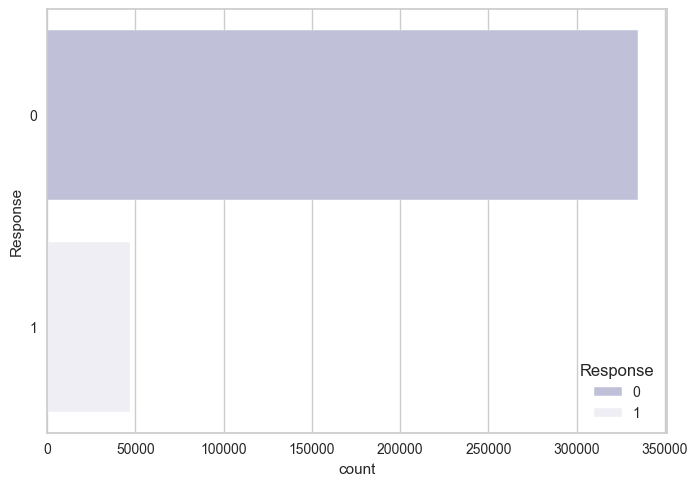

In [6]:
sns.countplot(df, y="Response", hue="Response", palette=["#bcbddc", "#efedf5"])

2. **`Gender`**

In [7]:
# Maschi e Femmine
df['Gender'].value_counts()

Gender
Male      206089
Female    175020
Name: count, dtype: int64

In [8]:
val_male = df[(df['Gender'] == 'Male') &  
    (df['Response'] == 1)]['id'].count()*100/df[df['Gender'] == 'Male']['id'].count()

print("Interessati all'assicurazione, sesso M (in %) :", round(val_male, 2))

val_female = df[(df['Gender'] == 'Female') &  
    (df['Response'] == 1)]['id'].count()*100/df[df['Gender'] == 'Female']['id'].count()

print("Interessati all'assicurazione, sesso F (in %) :", round(val_female, 2))

Interessati all'assicurazione, sesso M (in %) : 13.84
Interessati all'assicurazione, sesso F (in %) : 10.39


Text(0.5, 1.0, 'Response Rate by Gender')

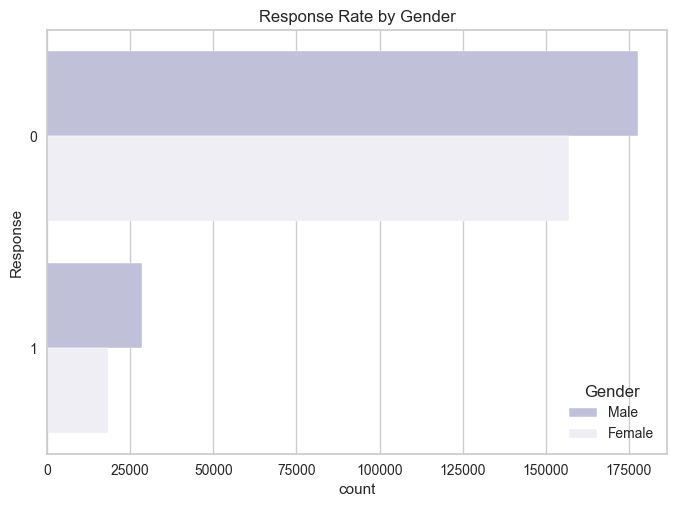

In [9]:
sns.countplot(y="Response", hue="Gender", data=df, palette=["#bcbddc", "#efedf5"])
plt.title("Response Rate by Gender")


Analisi della risposta positiva (1) , suddivisa per sesso

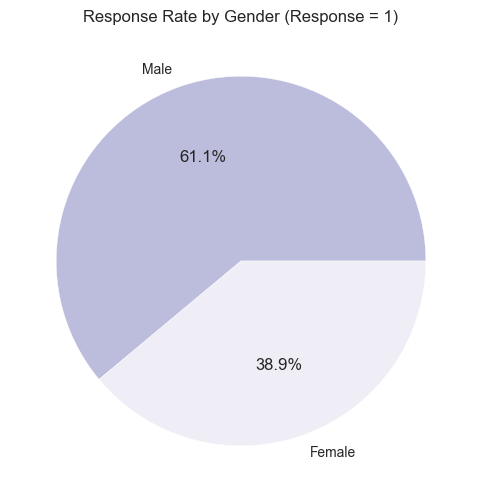

In [10]:
# Analisi della risposta dell'acquirente: 1 positivamente alla proposta di vendità, suddivisa in base al sesso
data = df[df['Response'] == 1]
gender_counts = data['Gender'].value_counts()

plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(gender_counts.values, labels=gender_counts.index, autopct="%1.1f%%", colors=["#bcbddc", "#efedf5"])
plt.title("Response Rate by Gender (Response = 1)")
plt.show()

Dal grafico possiamo osservare come si suddivide la popolazione, tra maschi e femmine, interassata positivamente alla proposta di vendita

3. **`Previously_Insured`**

In [11]:
# Risposte di chi era precedentemente assicurato ad una futura copertura.
previously_insured = df.groupby(['Previously_Insured', 'Response']).size().unstack()
previously_insured

Response,0,1
Previously_Insured,,
0,159929,46552
1,174470,158


Text(0.5, 1.0, 'Preference by those already covered by insurance (Response=1)')

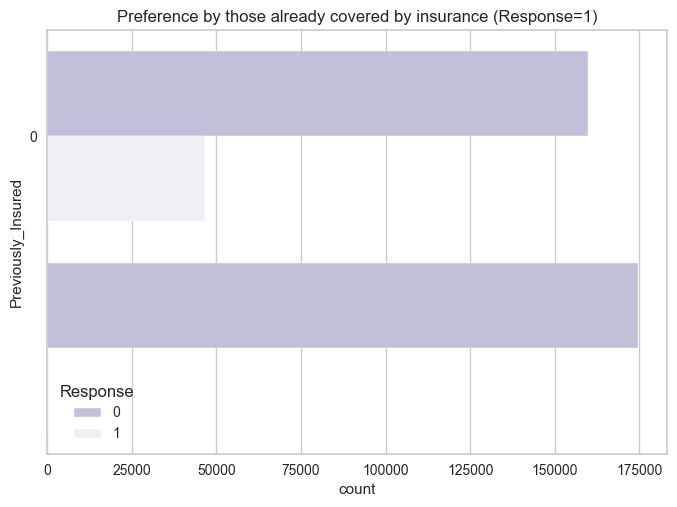

In [12]:
sns.countplot(y="Previously_Insured", hue="Response", data=df, palette=["#bcbddc", "#efedf5"])
plt.yticks(range(0, df['Response'].max() + 1, 500))
plt.title("Preference by those already covered by insurance (Response=1)")

4. **`Vehicle_Age`**

In [13]:
# Analisi dell'età dei veicoli suddivisi in base alla risposta del potenziale assicurato
vehicle_age = df.groupby(['Vehicle_Age', 'Response']).size().unstack()
vehicle_age

Response,0,1
Vehicle_Age,,
1-2 Year,165510,34806
< 1 Year,157584,7202
> 2 Years,11305,4702


Text(0.5, 1.0, 'Analysis of the age of the vehicles divided based on the response of the potential insured')

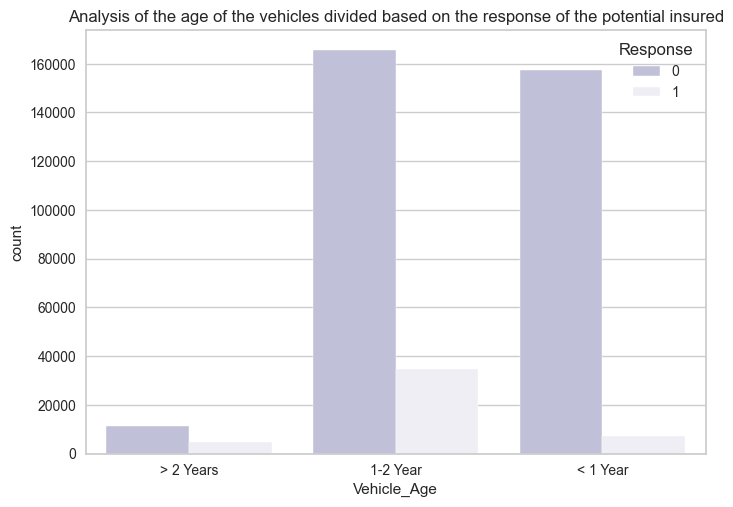

In [14]:
sns.countplot(x="Vehicle_Age", hue="Response", data=df, palette=["#bcbddc", "#efedf5"])
plt.title("Analysis of the age of the vehicles divided based on the response of the potential insured")

Se l'età del veicolo è inferiore ad 1 anno, è molto probabile che il cliente risponda NO.

5. **`Vehicle_Damage`**

In [15]:
vehicle_damage = df.groupby(['Vehicle_Damage', 'Response']).size().unstack()
vehicle_damage

Response,0,1
Vehicle_Damage,,
No,187714,982
Yes,146685,45728


Text(0.5, 1.0, 'Analysis of the age of the vehicles divided based on the response of the potential insured')

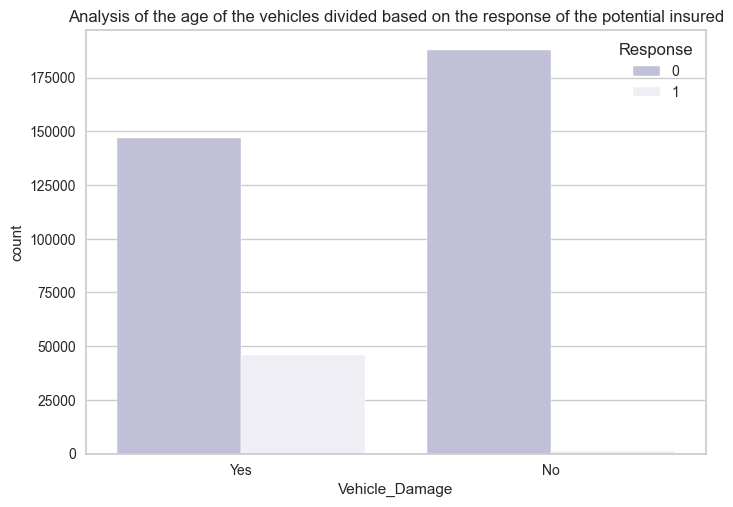

In [16]:
sns.countplot(x="Vehicle_Damage", hue="Response", data=df, palette=["#bcbddc", "#efedf5"])
plt.title("Analysis of the age of the vehicles divided based on the response of the potential insured")

I clienti che non hanno subito nessun incidente/danneggiamento, saranno più propensi a non sottoscrivere la polizza assicurative.

6. **`Age`**

Text(0.5, 1.0, 'How the age influence the variable target')

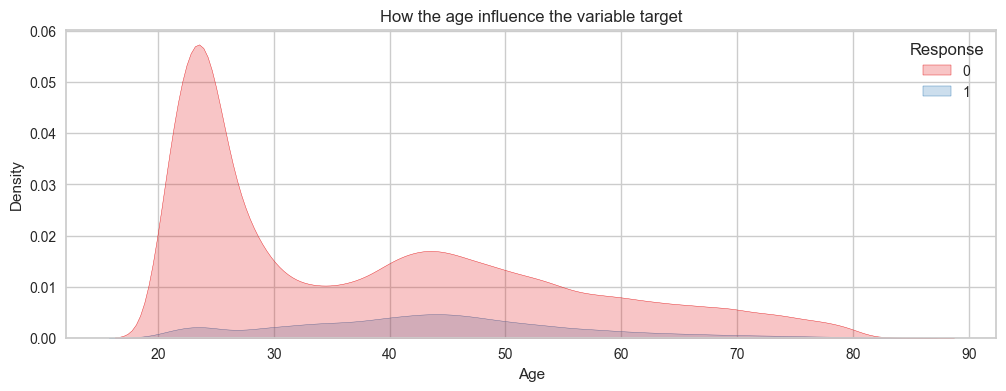

In [17]:
# Come l'età influenza la variabile target Response
plt.figure(figsize=(12, 4))
sns.kdeplot(x='Age', hue='Response', palette = 'Set1', fill=True, data=df)
#sns.FacetGrid(data = df, hue = 'Response',  height=6, aspect=.99, palette="rocket").map(sns.histplot, 'Age', kde=True).add_legend()
plt.title('How the age influence the variable target')

In [18]:
df['Age'].value_counts()

Age
24    25960
23    24256
22    20964
25    20636
21    16457
      ...  
81       56
82       29
83       22
84       11
85       11
Name: count, Length: 66, dtype: int64

Le persone con un età compresa tra i 20 e i 50 anni sono quelle hanno maggiori probabilità di stipulare un'assicurazione automobilistica. <br>
In questa fascia si distingue un momento compreso tra i 24 ed i 30 anni in cui si verifica una discesa e poi una risalita dei numeri dei sottoscrittori di polizza.<br>
Si può considerare questa feature come categorico e osservarne il risultato.

7. **`Driving_Licence`**

Text(0.5, 1.0, 'Analysis between those who have a driving license and are insured')

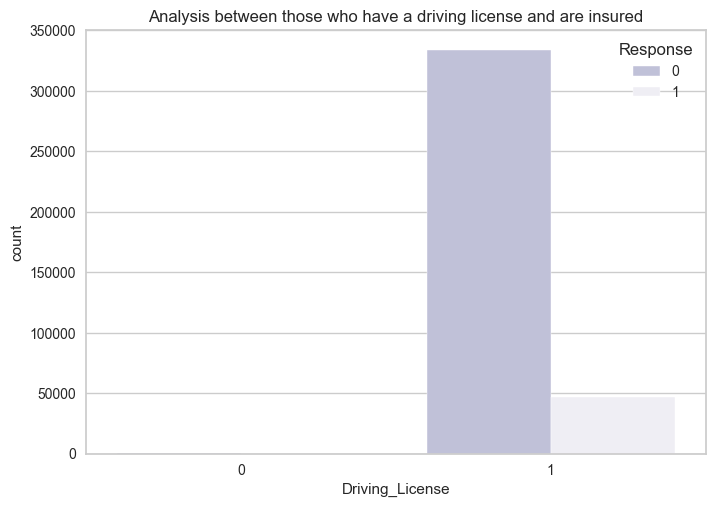

In [19]:
sns.countplot(x="Driving_License", hue="Response", data=df, palette=["#bcbddc", "#efedf5"])
plt.title("Analysis between those who have a driving license and are insured")

8. **`Annual_Premium`**

In [20]:
df['Annual_Premium'].describe()

count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

<Axes: xlabel='Annual_Premium', ylabel='Density'>

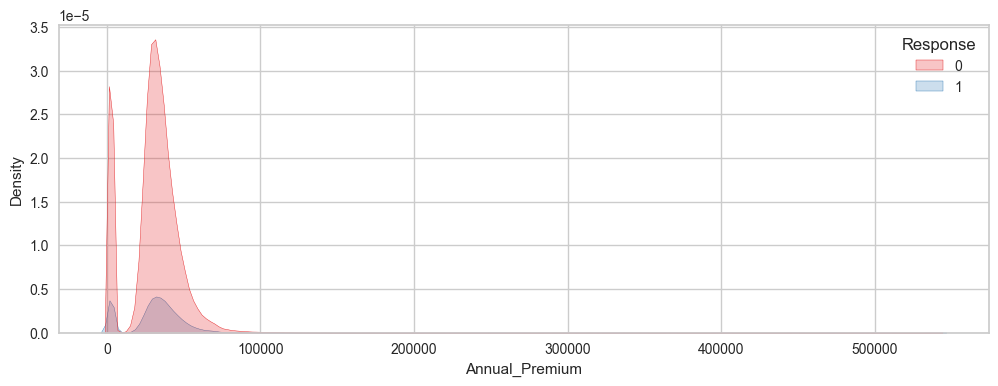

In [21]:
plt.figure(figsize=(12, 4))
sns.kdeplot(x='Annual_Premium', hue='Response', palette = 'Set1', fill=True, data=df)

In [22]:
#suddivido la variabile in intervalli e per ognuna di essa determino il valore della variablile Response
intervals = [0, 25000, 50000, 75000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000]
df["Annual_Premium_Interval"] = pd.cut(df["Annual_Premium"], intervals)
response_counts = df.groupby("Annual_Premium_Interval")["Response"].value_counts()

response_counts

C:\Users\s931243\AppData\Local\Temp\ipykernel_13948\1319236531.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  response_counts = df.groupby("Annual_Premium_Interval")["Response"].value_counts()


Annual_Premium_Interval  Response
(0, 25000]               0            89142
                         1            11821
(25000, 50000]           0           217952
                         1            29990
(50000, 75000]           0            24511
                         1             4404
(75000, 100000]          0             2139
                         1              372
(100000, 150000]         0              497
                         1               90
(150000, 200000]         0               68
                         1               11
(200000, 250000]         0               31
                         1                5
(250000, 300000]         0               17
                         1                8
(300000, 350000]         0               27
                         1                5
(350000, 400000]         0                6
                         1                0
(400000, 450000]         0                3
                         1                

In [23]:
df_premium = response_counts.to_frame(name="Count").reset_index()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, '(0, 25000]'),
  Text(1, 0, '(25000, 50000]'),
  Text(2, 0, '(50000, 75000]'),
  Text(3, 0, '(75000, 100000]'),
  Text(4, 0, '(100000, 150000]'),
  Text(5, 0, '(150000, 200000]'),
  Text(6, 0, '(200000, 250000]'),
  Text(7, 0, '(250000, 300000]'),
  Text(8, 0, '(300000, 350000]'),
  Text(9, 0, '(350000, 400000]'),
  Text(10, 0, '(400000, 450000]'),
  Text(11, 0, '(450000, 500000]'),
  Text(12, 0, '(500000, 550000]')])

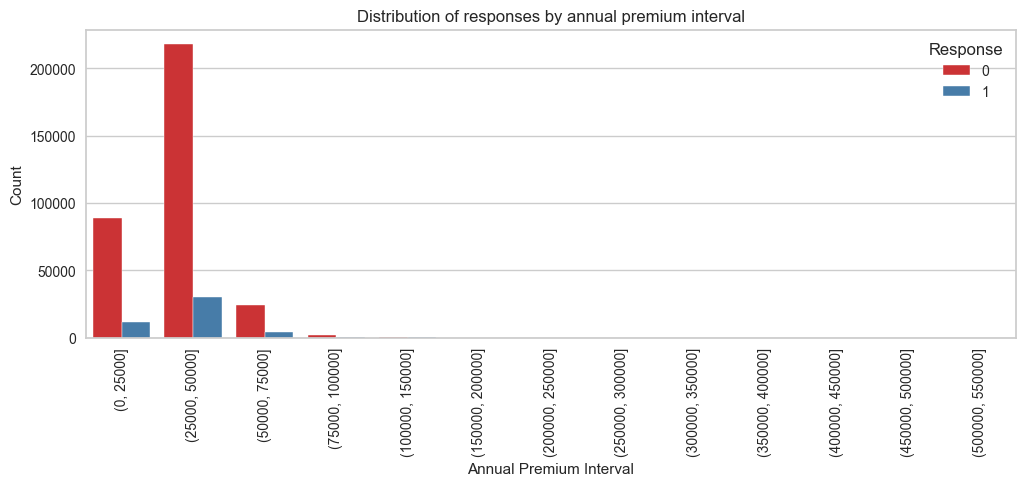

In [24]:
# Grafico a barre raggruppate con Seaborn
plt.figure(figsize=(12, 4))
sns.barplot(x="Annual_Premium_Interval", y="Count", hue="Response", palette = 'Set1', fill=True, data=df_premium)
plt.xlabel("Annual Premium Interval")
plt.ylabel("Count")
plt.title("Distribution of responses by annual premium interval")
plt.xticks(rotation=90)  # Ruota le etichette x per una migliore leggibilità


9. **`Policy_Sales_Channel`**

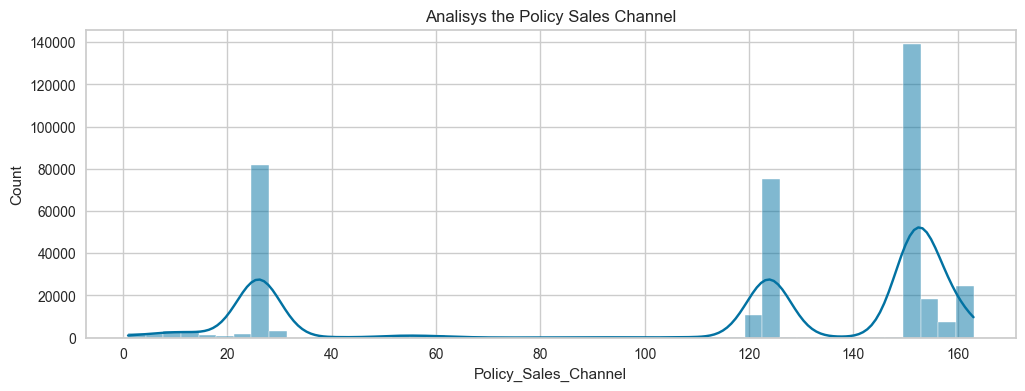

In [25]:
plt.figure(figsize=(12, 4))
sns.histplot(df['Policy_Sales_Channel'], kde=True)
plt.title('Analisys the Policy Sales Channel'.format('Policy_Sales_Channel'))
plt.show()

<Axes: xlabel='Policy_Sales_Channel', ylabel='Density'>

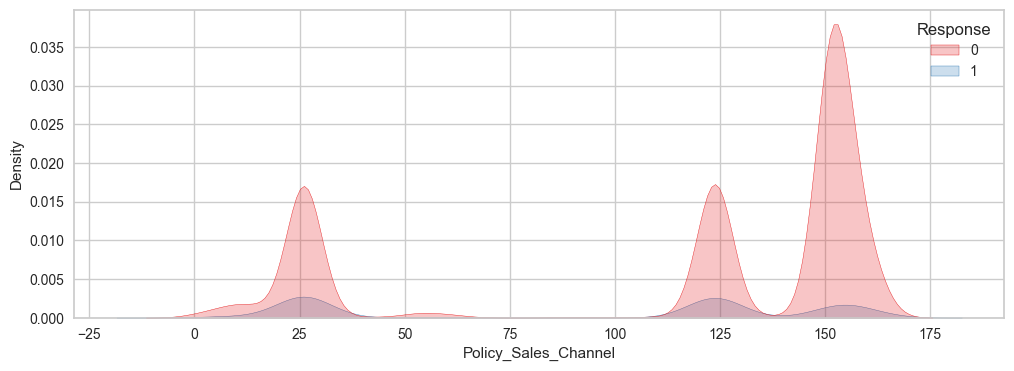

In [26]:
plt.figure(figsize=(12, 4))
sns.kdeplot(x=df['Policy_Sales_Channel'], hue='Response', palette = 'Set1', fill=True, data=df)

10. **`Vintage`**

In [27]:
df['Vintage'].describe()

count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

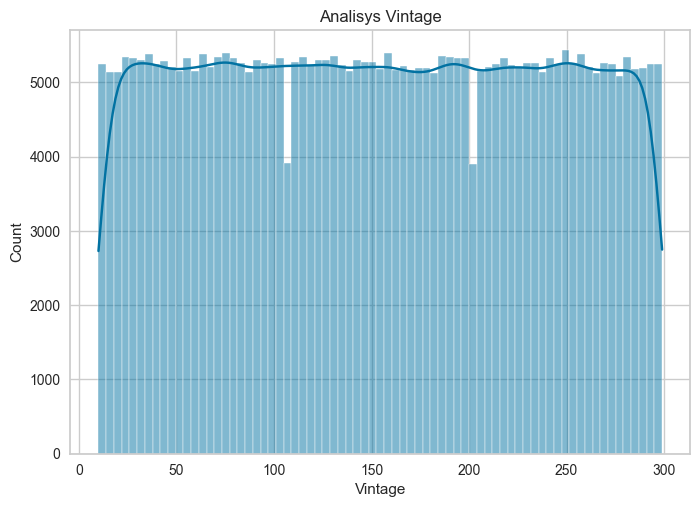

In [28]:
sns.histplot(df['Vintage'], kde=True)
plt.title('Analisys Vintage'.format('Vintage'))
plt.show()

<Axes: xlabel='Vintage', ylabel='Density'>

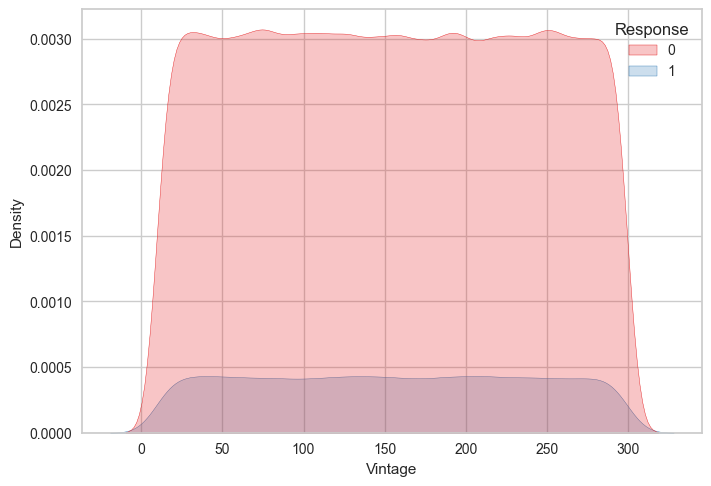

In [29]:
sns.kdeplot(x=df['Vintage'], hue='Response', palette = 'Set1', fill=True, data=df)

<Axes: xlabel='Vintage', ylabel='Density'>

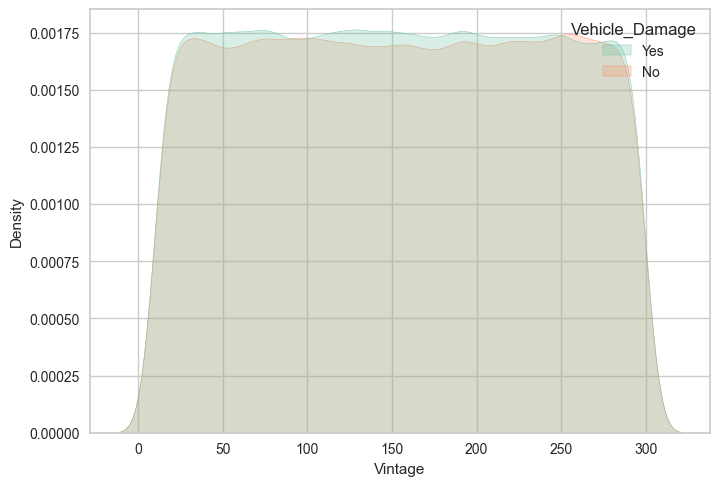

In [30]:
# Analisi tra le variabili Vintage e Vehicle_Damage
sns.kdeplot(x=df['Vintage'], hue='Vehicle_Damage', palette = 'Set2', fill=True, data=df)

Possiamo osservare come la distribuzione di chi ha subito almeno un danneggiamento alla propria autovettura e chi no, si equivalgono.

### `Pulizia dei dati e Pre-Processing`

In [31]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Annual_Premium_Interval
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,"(25000, 50000]"
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,"(25000, 50000]"
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,"(25000, 50000]"
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,"(25000, 50000]"
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,"(25000, 50000]"


#### `Label Encoded - One Hot Encoded feature categoriche e numeriche`

In [32]:
le= LabelEncoder()

df = df.iloc[:, 1:12]
df['Gender'] = le.fit_transform(df['Gender'])
df['Vehicle_Age'] = le.fit_transform(df['Vehicle_Age'])
df['Vehicle_Damage'] = le.fit_transform(df['Vehicle_Damage'])
df.head(15)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,0,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,1,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,1,0,27496.0,152.0,39,0
5,0,24,1,33.0,0,1,1,2630.0,160.0,176,0
6,1,23,1,11.0,0,1,1,23367.0,152.0,249,0
7,0,56,1,28.0,0,0,1,32031.0,26.0,72,1
8,0,24,1,3.0,1,1,0,27619.0,152.0,28,0
9,0,32,1,6.0,1,1,0,28771.0,152.0,80,0


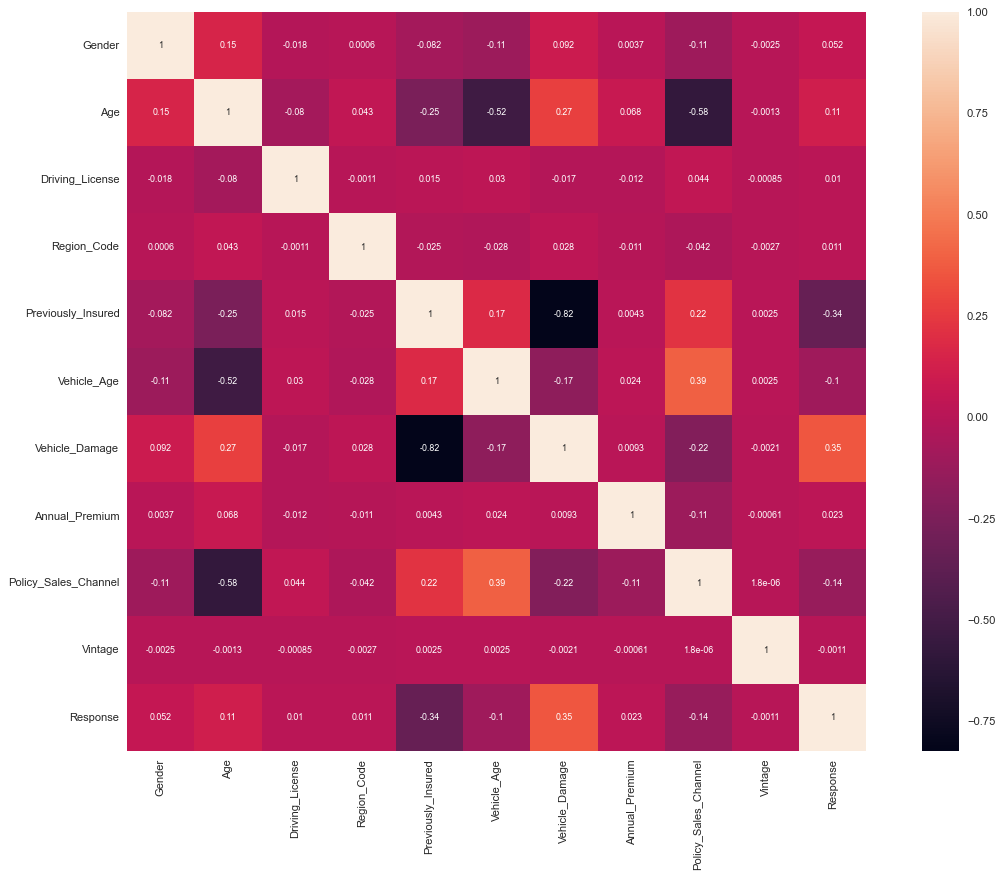

In [33]:
# Matrice di correlazione

data = df.corr().values
columns = df.columns
plt.figure(figsize=(18, 12), dpi=80)
mcorr = sns.heatmap(df.corr().values, 
            cbar=True,
            square=True,
            annot=True,
            xticklabels=df.columns,
            yticklabels=df.columns,
            annot_kws={'size': 8}
            )

plt.show()

In [34]:
# Separo le variabili

# dipendenti:
y = df['Response']      
# indipendenti
X = df.drop(columns='Response')        

In [35]:
from matplotlib import cm
color = cm.inferno_r(np.linspace(.4, .8, 30))

[0.00473567 0.14539207 0.00046886 0.10789918 0.06247417 0.01603885
 0.06740798 0.24624327 0.07227083 0.27706912]


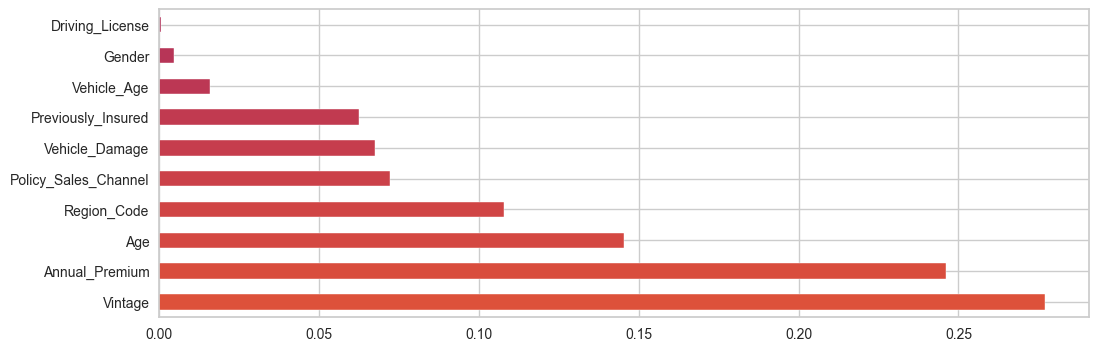

In [36]:
# selezione delle features

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) 

# grafico che rappresenta l'importanza delle features
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(11).plot(kind='barh', color=color, legend=False, figsize=(12, 4))
plt.show()

si può apprezzare come la variabile **`Driving_License`** è poco significativa, quindi può essere esclusa dallo studio

In [37]:
X = X.drop(['Driving_License'],axis=1) 

> Come analizzato in precedenza al punto 1, il database risulta essere sbilanciato, quindi per bilanciare utilizzo l'`oversampling`. <br>
Lo utilizzero dopo aver elaborato il dataset originale.

#### `SPLIT dataset in TRAIN E TEST`

In [39]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.20, random_state=0, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#scaling delle features
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

(304887, 9) (76222, 9) (304887,) (76222,)


> Utilizzo alcuni classificatori per analizzare il dataset: `LOGISTIC REGRESSION`, `RANDOM FOREST`, `KNN CLASSIFIER`, `DECISION TREE`

In [40]:
# classificatori utilizzati
models = {
    'Logistic_Regression': LogisticRegression(C=0.04, penalty='l2', solver='liblinear', max_iter=5000, multi_class='ovr'),
    'Random_Forest': RandomForestClassifier(n_estimators=300, criterion='gini'),
    'Knn_classifier': KNeighborsClassifier(n_neighbors=2),
    'Decision_tree': DecisionTreeClassifier(),
}

In [41]:
# funzione per la visualizzazione della curva ROC e delle feature importanti per ogni modello di classificatore
def visual_plot(model):
    """
    Visualizza la ROC Curve e le feature importanti per il modello.

    Args:
        model: Modello di Machine Learning da visualizzare.
    """

    match model:
        case KNeighborsClassifier():
            print("Not suported")
        case _:
            fig_1 = FeatureImportances(model)
            fig_1.fit(X_train, y_train)
            fig_1.show()
            visualizer = ROCAUC(model)
            visualizer.fit(X_train, y_train)     
            visualizer.score(X_test, y_test)        
            visualizer.show()

In [42]:
def model_eval(model, model_name, X_train, y_train, X_test, y_test):
    """
    Valuta un modello di machine learning e archivio i risultati in un dizionario.

    Args:
        model: modello di machine learning da valutare.
        model_name: Nome del modello.
        X_train: Training features.
        y_train: Training labels.
        X_test: Testing features.
        y_test: Testing labels.

    Returns:
        Un dizionario che contenente le metriche di valutazione del modello.
    """

    print("##########################################################################")

    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    roc_auc = round(roc_auc_score(y_test, y_pred), 2)
    scores = {
        "model_name": model_name,
        "accuracy": accuracy,
        "roc_auc": roc_auc,
    }

    report = classification_report(y_test, y_pred)

    rows_report = report.split('\n')
    rows_report = rows_report[2:]
    for row in rows_report:
        column = row.split()
        if len(column) > 2:
            classe = column[0]
            if classe not in ["accuracy", "macro avg", "weighted avg"]:
                scores.update({
                    "recall": column[2],
                    "precision": column[3],
                    "score_f1": column[4],
                })
    
    
    print(classification_report(y_test, y_pred))

    visual_plot(model)

    cm = confusion_matrix(y_test, y_pred, labels=unique_labels(y_test, y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion matrix for {model_name}")
    plt.show()


    return scores, model



##########################################################################


c:\Users\s931243\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\s931243\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\s931243\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66880
           1       0.00      0.00      0.00      9342

    accuracy                           0.88     76222
   macro avg       0.44      0.50      0.47     76222
weighted avg       0.77      0.88      0.82     76222



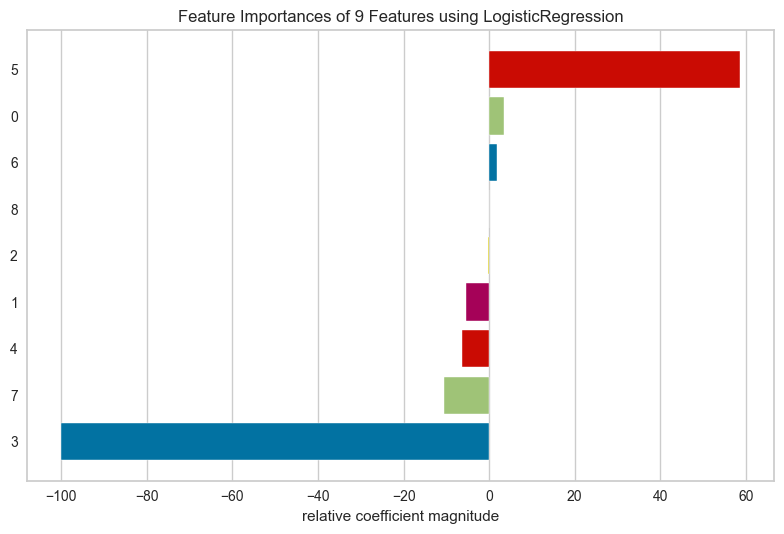

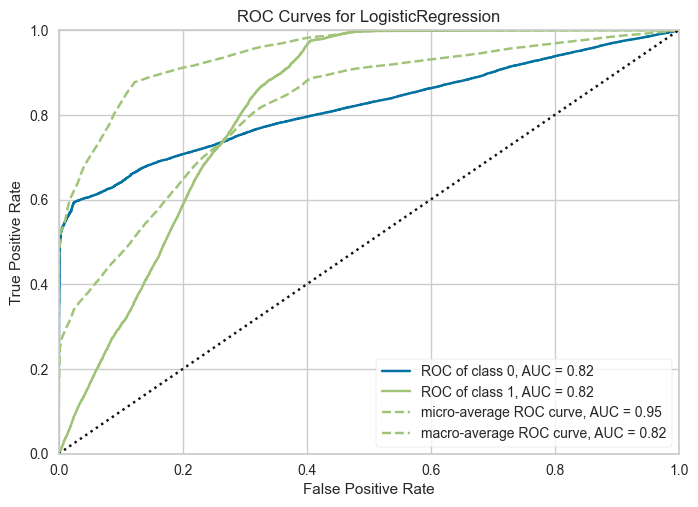

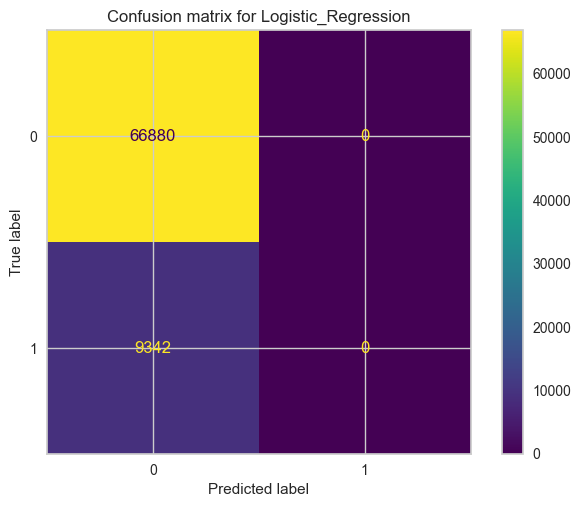

##########################################################################
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     66880
           1       0.36      0.12      0.18      9342

    accuracy                           0.87     76222
   macro avg       0.63      0.55      0.55     76222
weighted avg       0.82      0.87      0.84     76222



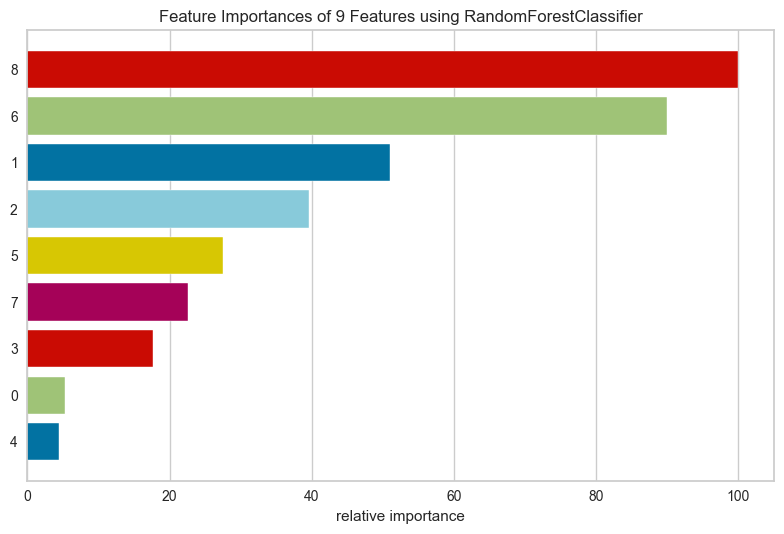

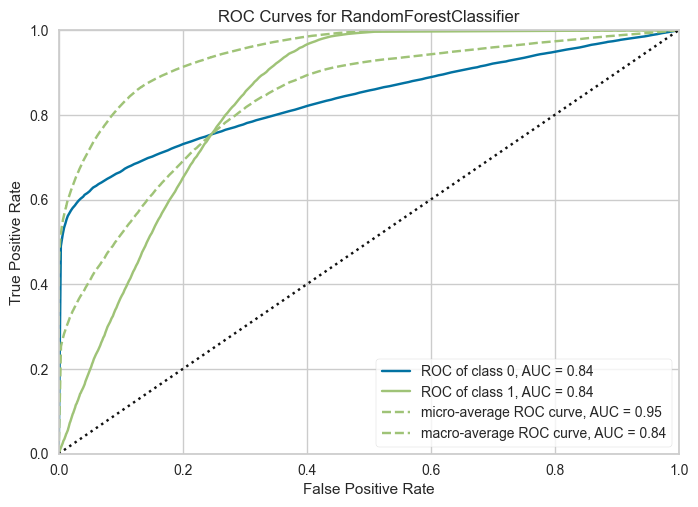

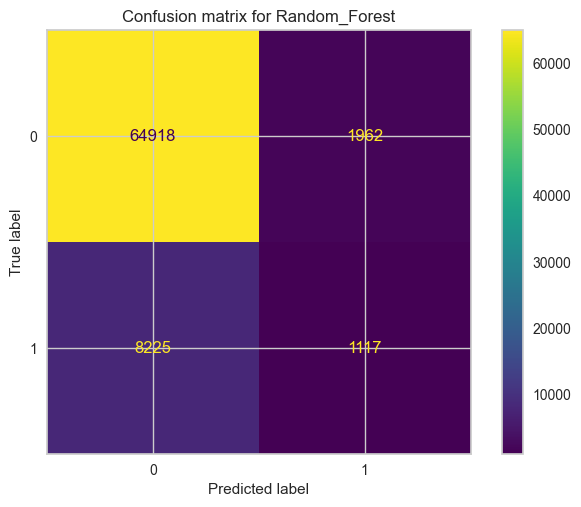

##########################################################################
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     66880
           1       0.32      0.10      0.15      9342

    accuracy                           0.86     76222
   macro avg       0.60      0.53      0.54     76222
weighted avg       0.82      0.86      0.83     76222

Not suported


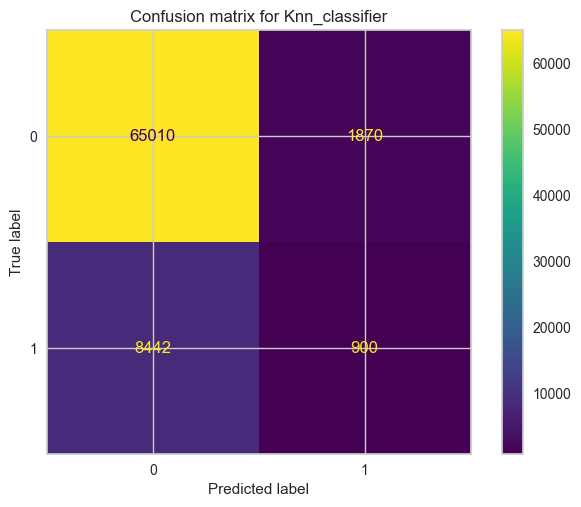

##########################################################################
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     66880
           1       0.29      0.31      0.30      9342

    accuracy                           0.82     76222
   macro avg       0.60      0.60      0.60     76222
weighted avg       0.83      0.82      0.83     76222



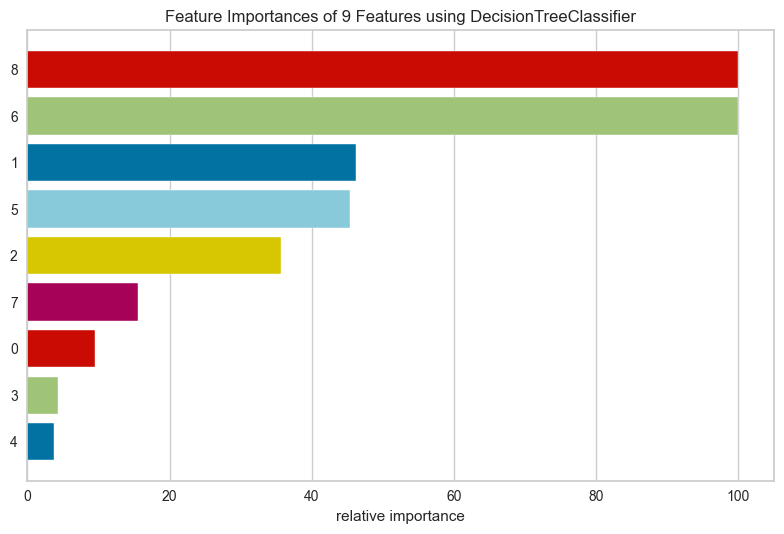

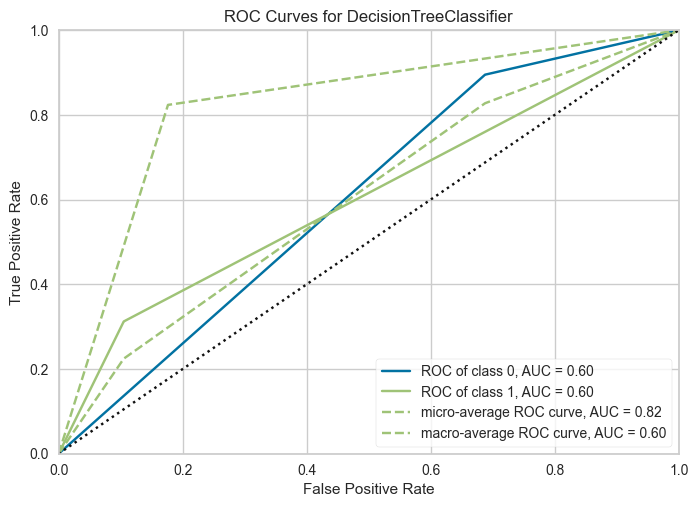

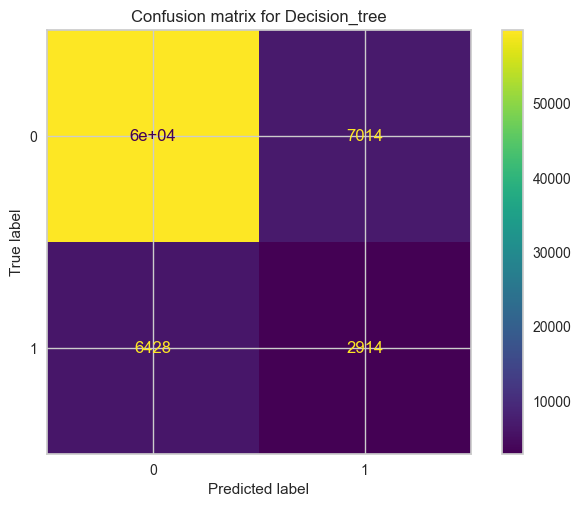

In [43]:
model_scores = []
for model_name, model in models.items():
    score, fitted_model = model_eval(model, model_name, X_train, y_train, X_test, y_test)
    model_scores.append(score)



In [44]:
# creazione del dataframe
df_scores = pd.DataFrame(model_scores)
df_scores

,model_name,accuracy,roc_auc,recall,precision,score_f1
0,Logistic_Regression,0.88,0.50,0.77,0.88,0.82
1,Random_Forest,0.87,0.55,0.82,0.87,0.84
2,Knn_classifier,0.86,0.53,0.82,0.86,0.83
3,Decision_tree,0.82,0.60,0.83,0.82,0.83


#### `SPLIT dataset bilanciato in TRAIN E TEST`

In [46]:
print(type(X_train))

<class 'numpy.ndarray'>


In [47]:
from imblearn.over_sampling import SMOTE
print(Counter(df.Response))
smote = SMOTE(random_state=0)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)
print(len(X_balanced))
print(len(y_balanced))

Counter({0: 334399, 1: 46710})
535038
535038


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=.20, random_state=0, stratify=y_balanced)

print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)
print('Bilanciamento', X_balanced.shape)

X_train shape (428030, 9)
X_test shape (107008, 9)
Bilanciamento (535038, 9)


##########################################################################
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     53504
           1       0.70      0.98      0.82     53504

    accuracy                           0.78    107008
   macro avg       0.83      0.78      0.78    107008
weighted avg       0.83      0.78      0.78    107008



c:\Users\s931243\AppData\Local\Programs\Python\Python312\Lib\site-packages\yellowbrick\model_selection\importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


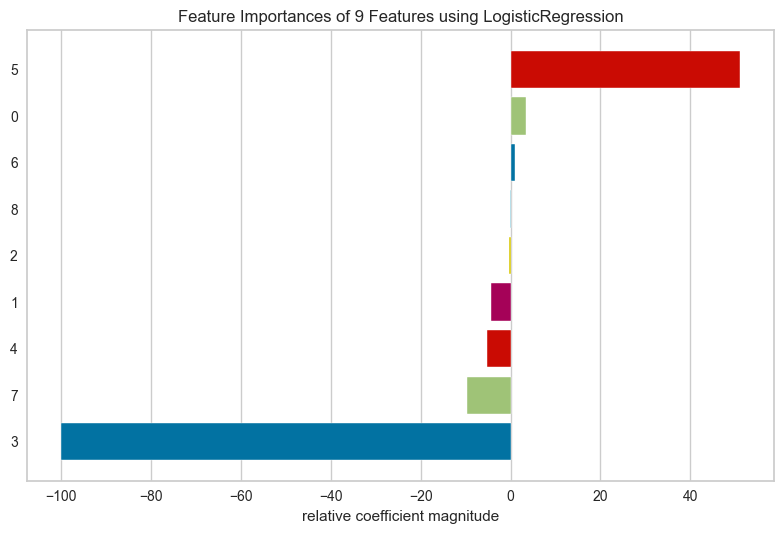

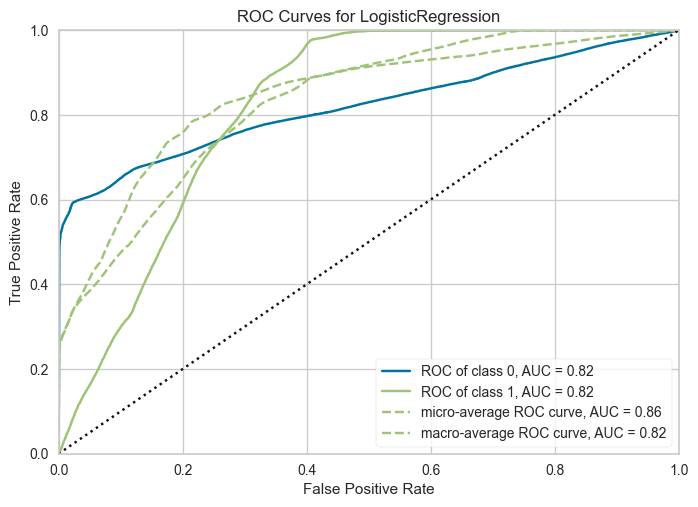

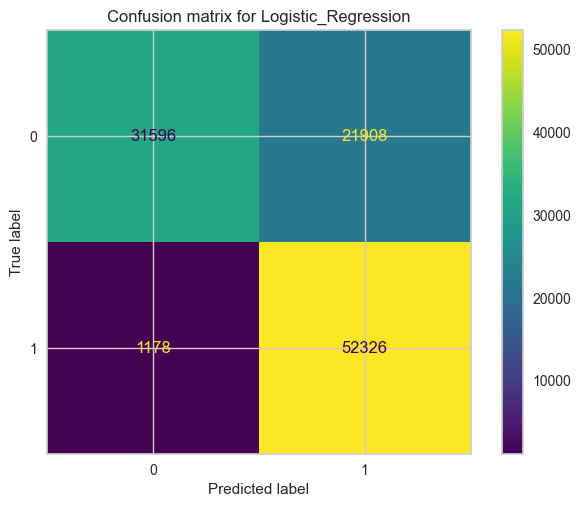

##########################################################################
              precision    recall  f1-score   support

           0       0.93      0.90      0.92     53504
           1       0.90      0.94      0.92     53504

    accuracy                           0.92    107008
   macro avg       0.92      0.92      0.92    107008
weighted avg       0.92      0.92      0.92    107008



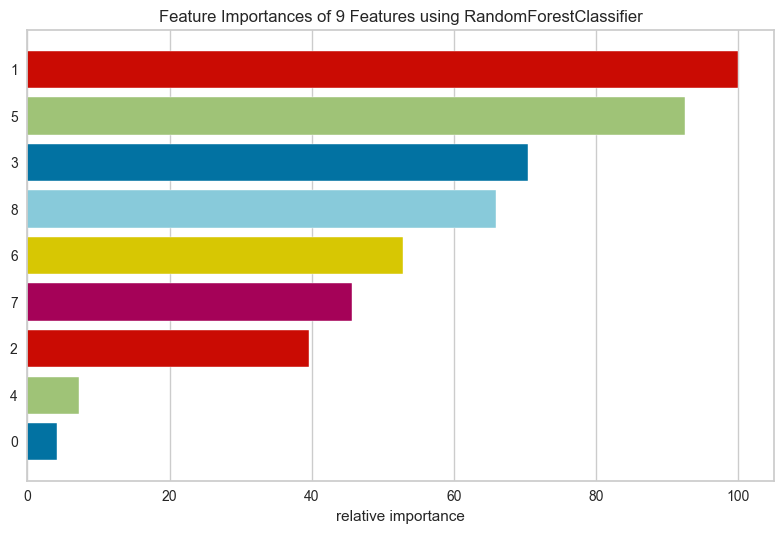

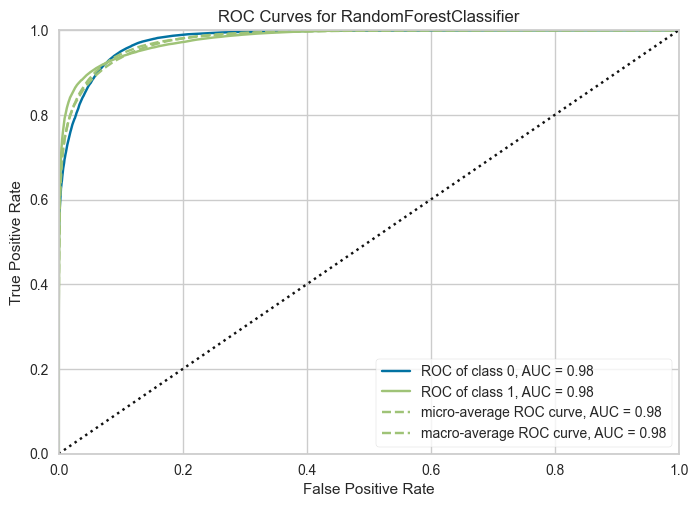

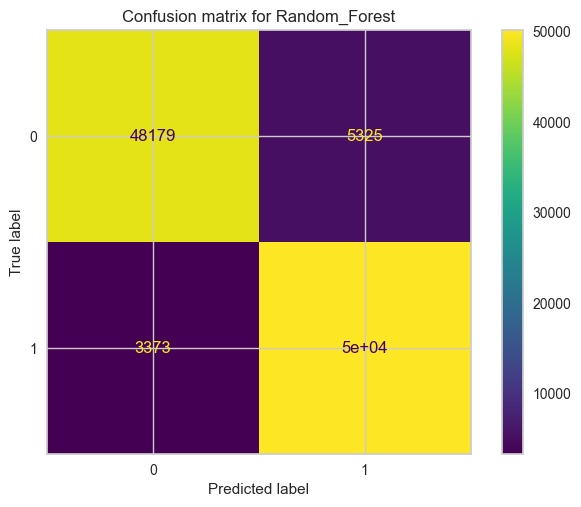

##########################################################################
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     53504
           1       0.87      0.91      0.89     53504

    accuracy                           0.89    107008
   macro avg       0.89      0.89      0.89    107008
weighted avg       0.89      0.89      0.89    107008

Not suported


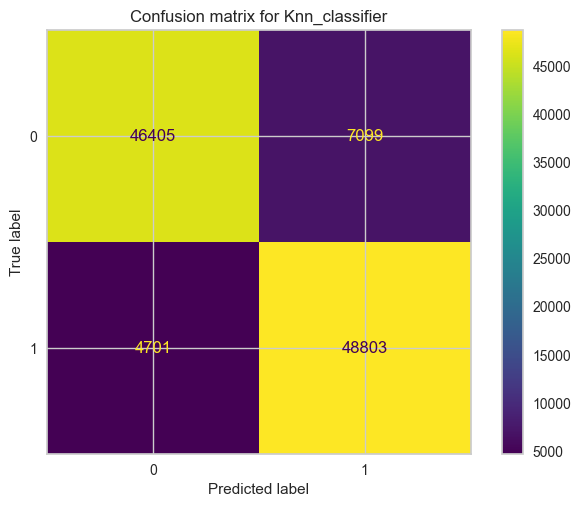

##########################################################################
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     53504
           1       0.89      0.90      0.89     53504

    accuracy                           0.89    107008
   macro avg       0.89      0.89      0.89    107008
weighted avg       0.89      0.89      0.89    107008



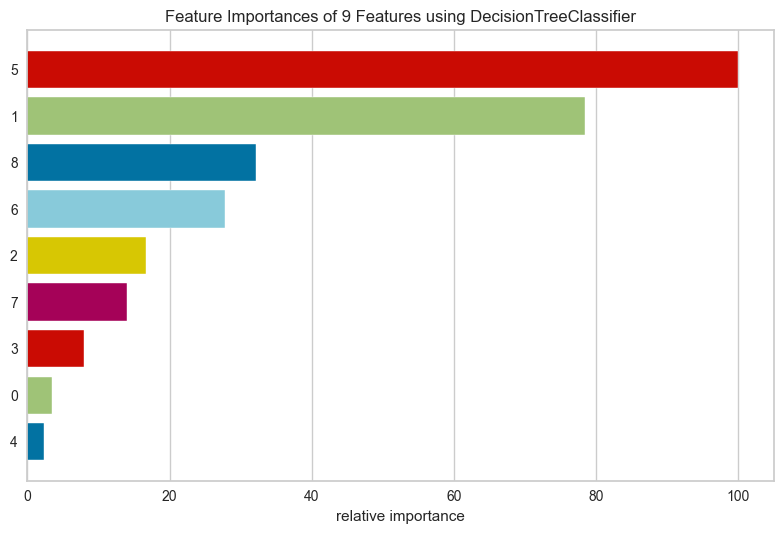

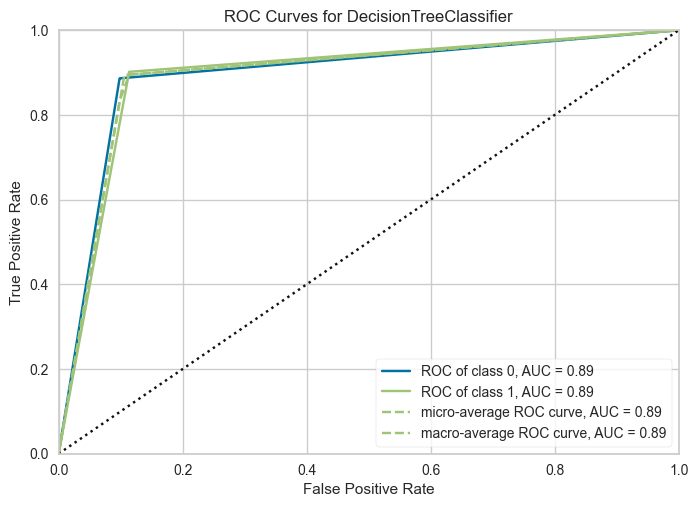

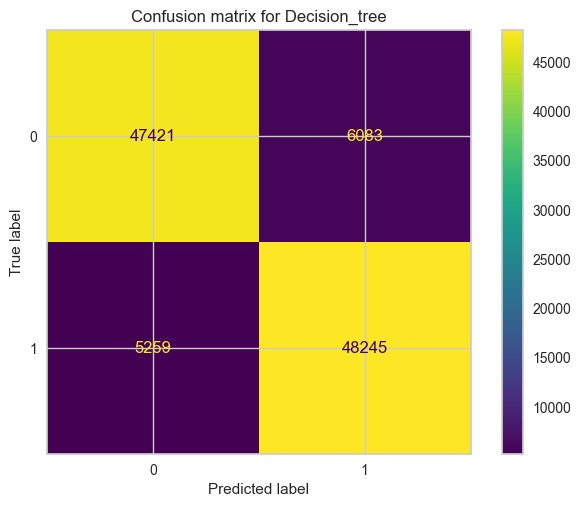

In [49]:
model_scores_balanced = []
for model_name, model in models.items():
    score_bal, fitted_model = model_eval(model, model_name, X_train, y_train, X_test, y_test)
    model_scores_balanced.append(score_bal)

In [50]:
# creazione del dataframe dati bilanciati
df_scores_bal = pd.DataFrame(model_scores_balanced)
df_scores_bal

,model_name,accuracy,roc_auc,recall,precision,score_f1
0,Logistic_Regression,0.78,0.78,0.83,0.78,0.78
1,Random_Forest,0.92,0.92,0.92,0.92,0.92
2,Knn_classifier,0.89,0.89,0.89,0.89,0.89
3,Decision_tree,0.89,0.89,0.89,0.89,0.89


In [52]:
my_model_bal = dict(zip(df_scores_bal['model_name'], df_scores_bal['accuracy']))
my_model_bal

{'Logistic_Regression': 0.78,
 'Random_Forest': 0.92,
 'Knn_classifier': 0.89,
 'Decision_tree': 0.89}

In [53]:
# ricerca del modello migliore, analizzando il valore dell'accuracy
# modello migliore fittizio di partenza
max_model_name_bal = my_model_bal['Random_Forest']
best_model_name_bal = list(my_model_bal)[1]
for i in my_model_bal.keys():
    if max_model_name_bal < my_model_bal[i]:
        max_model_name_bal = my_model_bal[i]
        best_model_name_bal = i

#### `Analisi del modello migliore`

In [54]:
# modello migliore
model = models[best_model_name_bal]
model

RandomForestClassifier(n_estimators=300)

#### `Conclusione`

1. La maggior parte dei clienti non è disposta a stipulare un'assicurazione per il veicolo.

2. Sono più gli uomini interessati ad ottenere un'assicurazione (61%) rispetto alle donne (38%)

3. In generale sono le persone con un'età compresa tra i 30 e i 50 anni le più interessate a ottenere un'assicurazione automobilistica

4. I più interessati sono i clienti che hanno un veicolo con garanzia di età per 1-2 anni

5. Clienti in possesso della patente di guida

6. Funzionalità come Vintage, Annual_Premium e Età influenzano la variabile target.

7. Confrontando i modelli sulla base della curva ROC, accuratezza, precisione, f1_score e richiamo, RandomForest è quello che da i risultati migliori.